In [8]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 
              'comp.sys.ibm.pc.hardware', 'sci.crypt']

In [4]:
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)
print(len(newsgroups_train.data))

3219


In [7]:
cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data)

In [9]:
np.set_printoptions(precision=3)

In [10]:
n_components = 10
lda = LatentDirichletAllocation(n_components=n_components, max_iter=10, topic_word_prior=1/n_components, doc_topic_prior=10/n_components, learning_method='batch', n_jobs=-1)

In [11]:
review_topics = lda.fit_transform(review_cv)

In [12]:
print(review_topics.shape)
print(review_topics[0])

(3219, 10)
[0.011 0.006 0.006 0.006 0.006 0.026 0.008 0.006 0.891 0.035]


In [13]:
gross_topic_weights = np.mean(review_topics, axis=0)
print(gross_topic_weights)

[0.058 0.127 0.125 0.136 0.061 0.108 0.068 0.077 0.139 0.101]


In [15]:
review_topics.shape

(3219, 10)

In [17]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [18]:
print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: space, technology, encryption, new, launch, chip, satellite, government, use, law
Topic #1: com, key, clipper, chip, encryption, government, keys, privacy, use, netcom
Topic #2: graphics, com, software, mail, image, data, ftp, university, available, ibm
Topic #3: scsi, card, drive, com, ide, university, bus, controller, nntp, host
Topic #4: bit, key, file, jpeg, use, files, image, version, gif, public
Topic #5: space, article, com, university, moon, just, henry, posting, orbit, toronto
Topic #6: nasa, article, sandvik, com, law, apple, gov, kent, people, newton
Topic #7: com, drive, ___, access, jpl, posting, nntp, host, digex, tape
Topic #8: people, god, don't, com, think, say, article, just, keith, does
Topic #9: jesus, people, god, just, like, good, know, time, bible, does



n_components: 6, perplexity: 3283.435
n_components: 7, perplexity: 3259.015
n_components: 8, perplexity: 3211.871
n_components: 9, perplexity: 3273.342
n_components: 10, perplexity: 3240.417
n_components: 11, perplexity: 3246.680
n_components: 12, perplexity: 3267.414
n_components: 13, perplexity: 3307.195
n_components: 14, perplexity: 3309.275
n_components: 15, perplexity: 3329.700


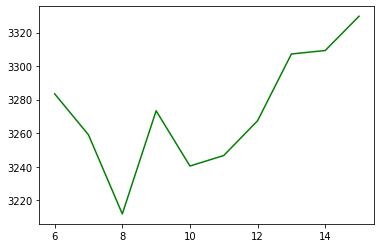

8

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior= 0.1, 
                    doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components = i, max_iter=max_iter, 
                                        topic_word_prior= topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior,
                                        learning_method='batch', n_jobs= -1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

show_perplexity(review_cv, start=6, end=15)

In [20]:
lda = LatentDirichletAllocation(n_components = 8, #추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior= 0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs= -1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: key, encryption, clipper, chip, government, use, public, security, keys, privacy
Topic #1: drive, scsi, card, university, ide, controller, disk, bus, hard, host
Topic #2: com, article, nntp, posting, host, i'm, just, netcom, like, don't
Topic #3: god, jesus, people, does, bible, believe, just, time, say, good
Topic #4: space, nasa, gov, information, research, center, faq, university, sci, 1993
Topic #5: space, article, launch, moon, orbit, access, nasa, just, earth, henry
Topic #6: graphics, image, file, files, software, ftp, version, program, mail, available
Topic #7: people, com, don't, article, think, say, keith, morality, just, like

